# Enfoque 2 (Series Temporales) - Fase 2 Optimización (GRID HGB criterio RMSE penalizado) + Inputs Trat 2

In [ ]:
import pandas as pd
import numpy as np


# Gráficos
import matplotlib.pyplot as plt


# Preprocesado y modelado

from sklearn.model_selection import KFold,cross_validate
from sklearn.ensemble import HistGradientBoostingRegressor

from tqdm.auto import tqdm
# Para Importar funciones generadas ad-hoc
import importlib
import TFM_errores as tfm_err
importlib.reload(tfm_err)

C:\Users\Elena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe
C:\Users\Elena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe


C:\Users\Elena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'TFM_errores' from 'c:\\Users\\Elena\\OneDrive\\Desktop\\Proyecto PY KSChool_1\\TFM\\TFM_errores.py'>

## Carga DATOS INPUTS - Tratados 2 (con variables adiconales)

In [ ]:
df_total = pd.read_csv('SET_INPUTS_TRAT_2.csv', sep=',', encoding='latin-1')

# 1) Asegura orden temporal (ajusta nombres de columnas)
df_total = df_total.sort_values(["time_idx"]).reset_index(drop=True)

# 2) Define features y target
X = df_total.drop(columns=['Price_Elec_EUR_MWh','Year','Month','Day','DayOfYear'], axis=1)
y = df_total['Price_Elec_EUR_MWh']

## División datos (TimeSeries)

In [4]:
# División de los datos en train y test
X = X.sort_values(["time_idx"]).reset_index(drop=True)
y = y.loc[X.index]

train_size = 0.8
split = int(train_size * len(X))

X_train = X.iloc[:split]
X_test  = X.iloc[split:]

y_train = y.iloc[:split]
y_test  = y.iloc[split:]

# Prepara X una sola vez
X_train_drop = X_train.drop(columns=["time_idx"])

# Optimización con RMSE- SAco métricas para penalizar YO

In [ ]:
# -----------------------
# Grid (alrededor del óptimo)
# Óptimo previo:
# l2=0.001, lr=0.1, depth=8, max_iter=1500, leaf=50
# -----------------------
# -----------------------
# Grid reducida (alrededor del óptimo)
# -----------------------
v_depth = [5, 8]                 # profundidad cercana al óptimo
v_iter  = [800, 1200, 1500]       # menos iteraciones
v_leaf  = [30, 50]               # regularización estructural
v_l2    = [1e-4, 1e-3]            # alrededor del óptimo
v_lr    = [0.05, 0.1]             # learning rate conservador

# Configura CV

cv = KFold(n_splits=5, shuffle=True, random_state=42)


rows = []

# (Opcional) plot tipo "curvas" fijando algunas cosas
# Por ejemplo: fijamos lr y l2 y leaf, y dibujamos depth como series vs max_iter
plot_lr = 0.1
plot_l2 = 1e-3
plot_leaf = 50
plot_depths = [5, 8, None]
plot_iters = v_iter

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

for depth in plot_depths:
    rmse_train_mean = np.zeros(len(plot_iters))
    rmse_val_mean   = np.zeros(len(plot_iters))

    for i, iters in enumerate(plot_iters):
        hgb = HistGradientBoostingRegressor(
            random_state=42,
            loss="squared_error",
            max_depth=depth,
            max_iter=iters,
            min_samples_leaf=plot_leaf,
            l2_regularization=plot_l2,
            learning_rate=plot_lr
        )

        cv_out = cross_validate(
            hgb,
            X_train_drop,
            y_train,
            cv=cv,
            scoring="neg_root_mean_squared_error",
            return_train_score=True,
            n_jobs=1
        )

        train_rmse_folds = -cv_out["train_score"]
        val_rmse_folds   = -cv_out["test_score"]

        rmse_train_mean[i] = train_rmse_folds.mean()
        rmse_val_mean[i]   = val_rmse_folds.mean()

    label = f"depth={depth}"
    ax[0].plot(plot_iters, rmse_train_mean, marker="o", label=label)
    ax[1].plot(plot_iters, rmse_val_mean,   marker="o", label=label)

# ---- estética ----
ax[0].set_title("RMSE CV - Train (HGB)")
ax[1].set_title("RMSE CV - Validación (HGB)")

for a in ax:
    a.set_xscale("log")
    a.set_xlabel("max_iter (iteraciones boosting)")
    a.set_ylabel("RMSE (€/MWh)")
    a.grid(True)
    a.legend()

fig.tight_layout()
plt.show()

# -----------------------
# Barrido COMPLETO: guarda toda la grid
# -----------------------
for depth in v_depth:
    for iters in v_iter:
        for leaf in v_leaf:
            for l2 in v_l2:
                for lr in v_lr:
                    hgb = HistGradientBoostingRegressor(
                        random_state=42,
                        loss="squared_error",
                        max_depth=depth,
                        max_iter=iters,
                        min_samples_leaf=leaf,
                        l2_regularization=l2,
                        learning_rate=lr
                    )

                    cv_out = cross_validate(
                        hgb,
                        X_train_drop,
                        y_train,
                        cv=cv,
                        scoring="neg_root_mean_squared_error",
                        return_train_score=True,
                        n_jobs=1
                    )

                    train_rmse_folds = -cv_out["train_score"]
                    val_rmse_folds   = -cv_out["test_score"]

                    rows.append({
                        "max_depth": depth,
                        "max_iter": iters,
                        "min_samples_leaf": leaf,
                        "l2_regularization": l2,
                        "learning_rate": lr,

                        "rmse_train_mean": train_rmse_folds.mean(),
                        "rmse_train_std":  train_rmse_folds.std(ddof=1),

                        "rmse_val_mean":   val_rmse_folds.mean(),
                        "rmse_val_std":    val_rmse_folds.std(ddof=1),

                        "gap_mean":        (val_rmse_folds - train_rmse_folds).mean(),
                        "gap_pos_mean":    np.maximum(0.0, val_rmse_folds - train_rmse_folds).mean(),
                    })

df_grid_hgb = (
    pd.DataFrame(rows)
      .sort_values(["rmse_val_mean", "gap_pos_mean"])
      .reset_index(drop=True)
)

df_grid_hgb.to_excel("E2_TEMP_Opt2_RMSE_HGB_grid_cv.xlsx", index=False)

print("Grid guardada en df_grid_hgb y en hgb_Temporal_grid_cv_rmse_TOTAL.csv")


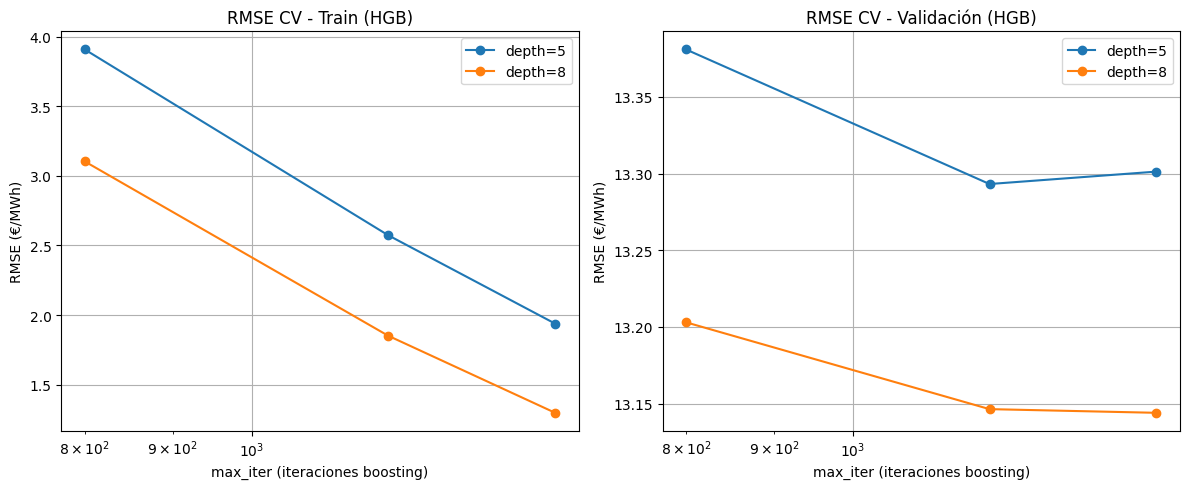

In [8]:
df_slice = df_grid_hgb[
    (df_grid_hgb["min_samples_leaf"] == 50) &
    (df_grid_hgb["l2_regularization"] == 1e-3) &
    (df_grid_hgb["learning_rate"] == 0.1)
].copy()
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

for depth in sorted(df_slice["max_depth"].unique(), key=lambda x: (x is None, x)):
    df_d = df_slice[df_slice["max_depth"] == depth].sort_values("max_iter")

    label = f"depth={depth}"

    ax[0].plot(
        df_d["max_iter"],
        df_d["rmse_train_mean"],
        marker="o",
        label=label
    )

    ax[1].plot(
        df_d["max_iter"],
        df_d["rmse_val_mean"],
        marker="o",
        label=label
    )

# ---- estética ----
ax[0].set_title("RMSE CV - Train (HGB)")
ax[1].set_title("RMSE CV - Validación (HGB)")

for a in ax:
    a.set_xscale("log")
    a.set_xlabel("max_iter (iteraciones boosting)")
    a.set_ylabel("RMSE (€/MWh)")
    a.grid(True)
    a.legend()

fig.tight_layout()
plt.show()

## 1. Selección y entrenamiento del modelo


In [5]:
# model = RandomForestRegressor(max_leaf_nodes=50, n_estimators=1000)
model = HistGradientBoostingRegressor(
            random_state=42,
            loss="squared_error",
            max_depth=8,
            max_iter=1500,
            min_samples_leaf=30,
            l2_regularization=1e-4,
            learning_rate=0.1
)
X_train_drop= X_train.drop(columns=["time_idx"])
X_test_drop= X_test.drop(columns=["time_idx"])

model.fit(X_train_drop, y_train)

y_train_pred = model.predict(X_train_drop)
y_test_pred = model.predict(X_test_drop)

## 2. Análisis de OUTPUTS

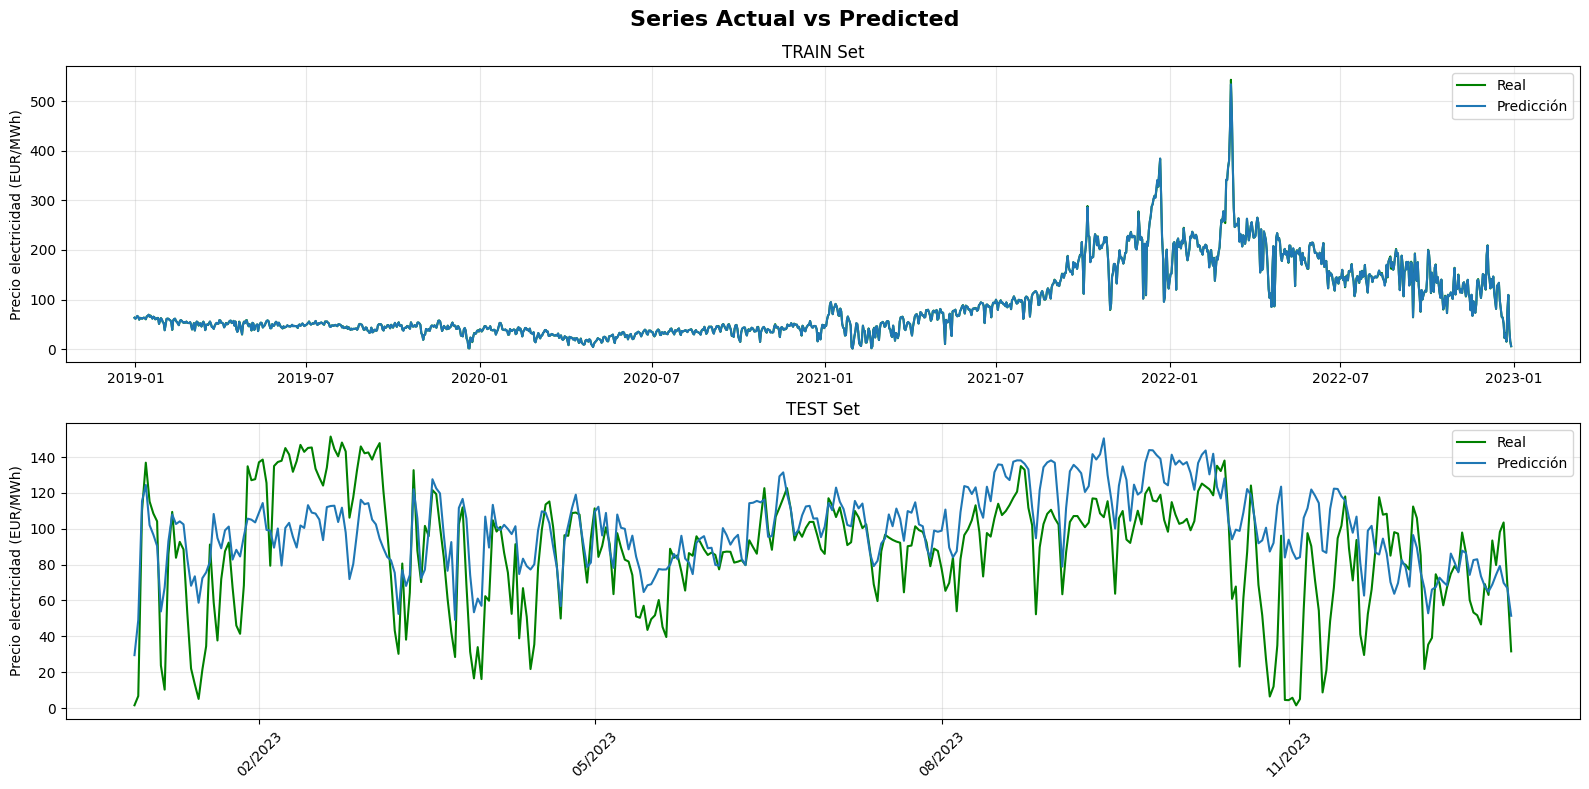


El error (rmse) de train es: 0.58 EUR/MWh
MAPE de train = 0.55 %
WAPE de train = 0.35 %
R2 train = 0.9999


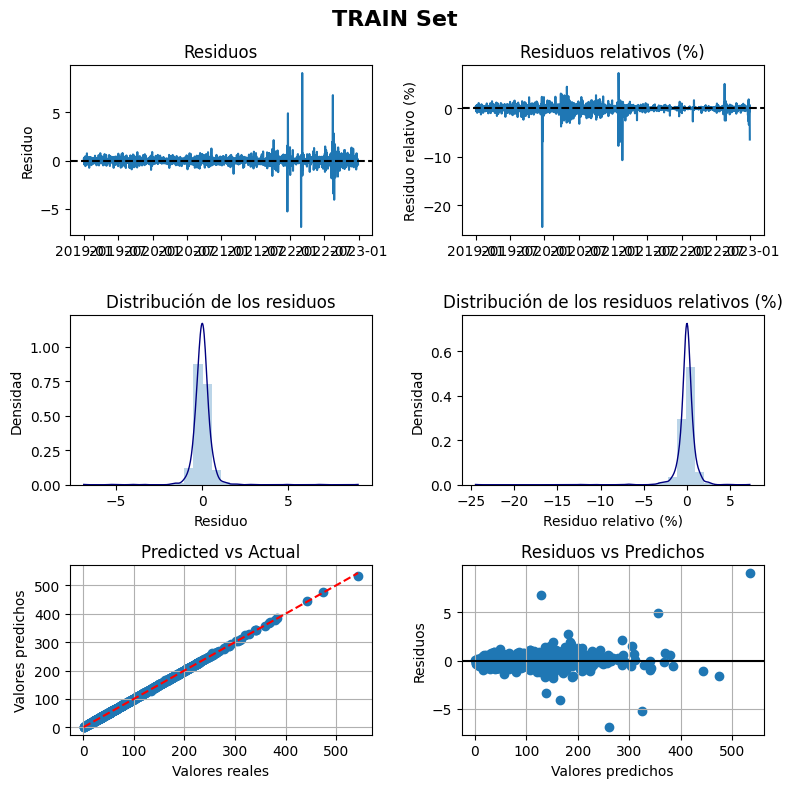


El error (rmse) de test es: 28.29 EUR/MWh
MAPE de test = 83.90 %
WAPE de test = 25.18 %
R2 test = 0.2570


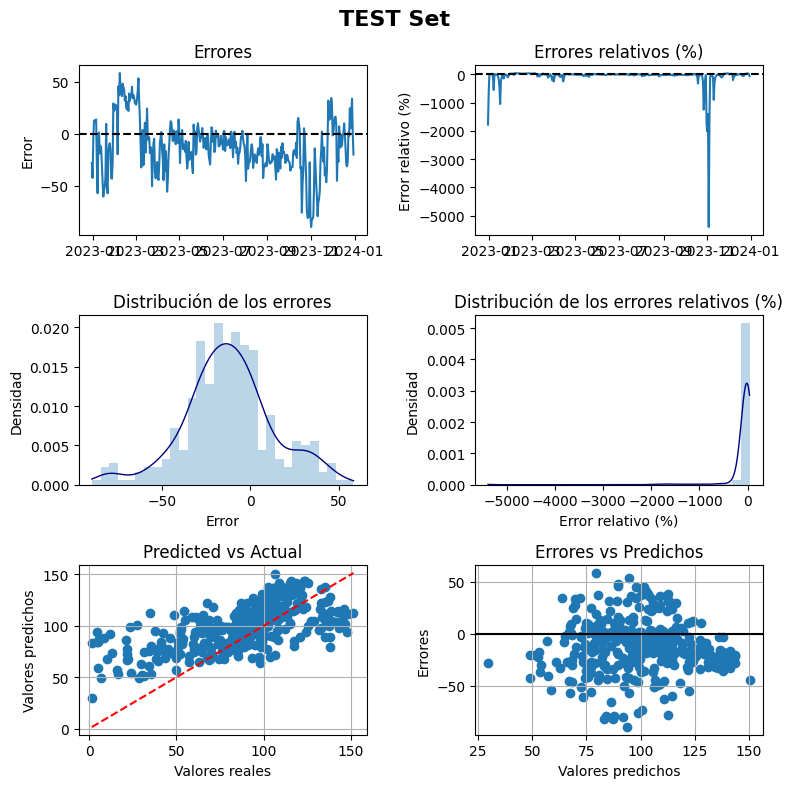

In [6]:
tfm_err.estudio_residuos_errores_index(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred)

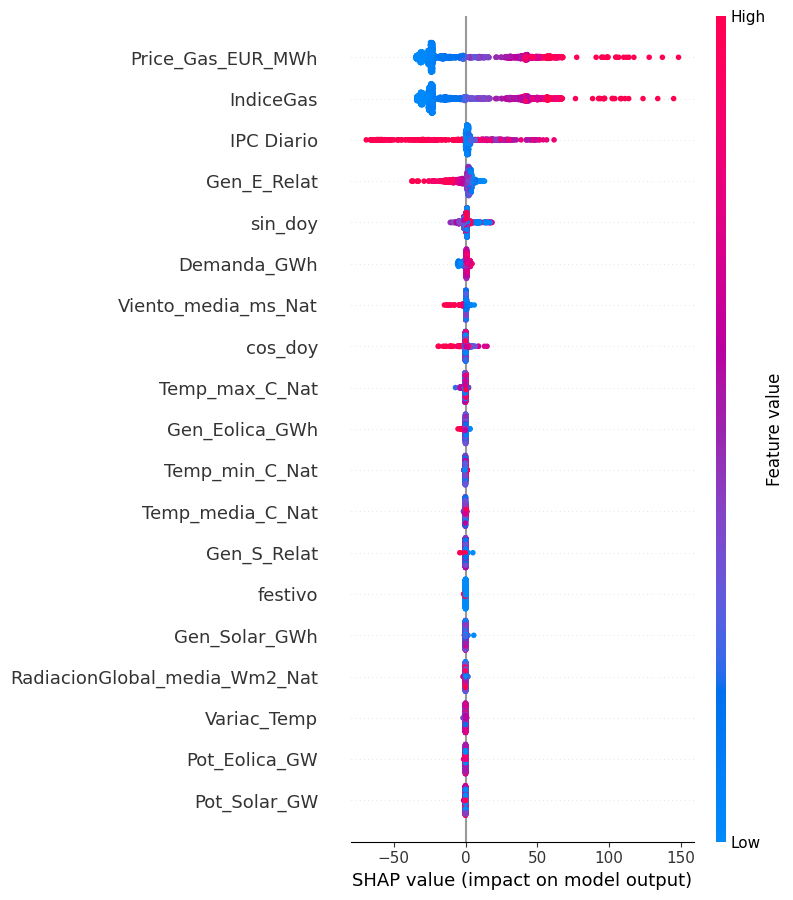

In [20]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_drop)

# Importancia global
shap.summary_plot(shap_values, X_train_drop)

In [17]:
shap_values.shape


(1460, 20)